도훈이가 만든 LSTM -> pytorch로 바꾸기

In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
import pickle
import matplotlib.pyplot as plt

In [2]:
print(torch.cuda.device_count())
print(torch.cuda.is_available())
print(torch.version.cuda)

1
True
11.8


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [4]:
import random

#Set seed
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

[[ 0.36328772  0.35860745  0.34462677  0.        ]
 [-8.28879996 -8.34585117 -9.41534225  0.        ]
 [-8.32494661 -8.5007654  -9.38263813  0.        ]
 ...
 [-0.04565476  0.24840068  0.51171683  0.        ]
 [-0.01865059  0.23539867  0.49171374  0.        ]
 [-0.03465306  0.2323982   0.48871328  0.        ]]


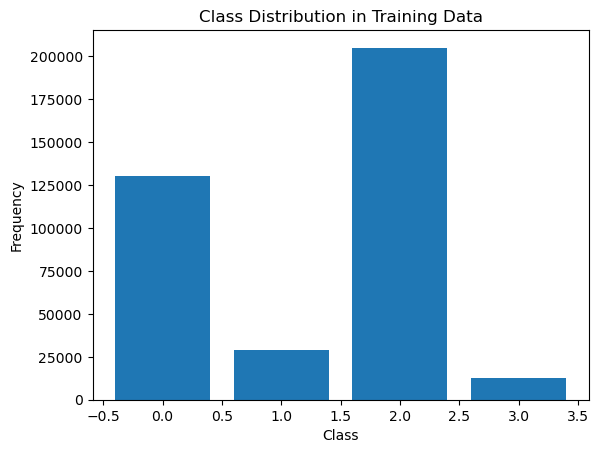

(376687, 3)


In [5]:

# 데이터 로드 및 전처리 함수
def load_and_preprocess(file_path):
    df = pd.read_csv(file_path, header=None)
    data = df.values
    return data

# 다중 타임 스텝 데이터를 생성하는 함수
def create_multistep_data(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps, :-1])
        y.append(data[i + time_steps, -1])
    return np.array(X), np.array(y)

# 모든 학습 데이터 로드 및 병합
all_data = []

file_paths = [f"C:\\Users\\jy\\Desktop\\code\\ReLabeling\\labeled\\Denormalize\\F{i}_combined.csv" for i in range(1, 51)]
for file_path in file_paths:
    data = load_and_preprocess(file_path)
    all_data.append(data)

all_data = np.vstack(all_data)

print(all_data)

# 데이터 분포 확인
plt.hist(all_data[:, 3], bins=range(5), align='left', rwidth=0.8)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution in Training Data')
plt.show()

print(all_data[:, :3].shape)

In [6]:
# 다중 타임 스텝 데이터 생성
time_steps = 30  # 예시로 3개의 타임 스텝을 고려
X, y = create_multistep_data(all_data, time_steps)
y = y.astype(int)

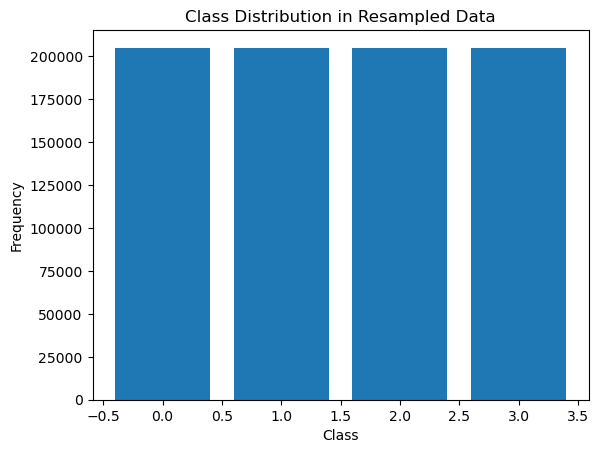

In [7]:

# 데이터 증강 (SMOTE)
smote = SMOTE()
X_reshaped = X.reshape(X.shape[0], -1)  # SMOTE를 적용하기 위해 2D 형태로 변환
X_res, y_res = smote.fit_resample(X_reshaped, y)
X_res = X_res.reshape(X_res.shape[0], time_steps, X.shape[2])  # 다시 3D 형태로 변환

# 증강된 데이터의 클래스 분포 확인
plt.hist(y_res, bins=range(5), align='left', rwidth=0.8)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution in Resampled Data')
plt.show()

In [8]:
# PyTorch 데이터셋 및 데이터로더 생성
X_tensor = torch.tensor(X_res, dtype=torch.float32)
y_tensor = torch.tensor(y_res, dtype=torch.long)
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)

In [9]:
# LSTM 모델 정의
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(hidden_size, 64)
        self.fc2 = nn.Linear(64, output_size)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]
        x = self.dropout(lstm_out)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

input_size = X_res.shape[2]
hidden_size = 512
output_size = 4
model = LSTMModel(input_size, hidden_size, output_size).to(device)

# 손실 함수 및 옵티마이저 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        """
        Args:
            patience (int): Loss가 개선되지 않는 epoch 수
            min_delta (float): 이전 Loss 대비 개선된 것으로 인정할 최소 감소량
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# 학습 루프에 조기 중단 로직 적용
early_stopping = EarlyStopping(patience=5, min_delta=0.1)

In [11]:
import matplotlib.pyplot as plt

num_epochs=100

# 학습 및 검증 손실과 정확도를 저장할 리스트
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

def train_epoch(model, data_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch in data_loader:
        inputs, labels = batch[:2]
        inputs = inputs.to(device)
        labels = labels.to(device)
        # print(inputs.shape)
        # raise 1000
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(data_loader)
    accuracy = correct / total
    return avg_loss, accuracy

def e_model(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in data_loader:
            inputs, labels = batch[:2]
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(data_loader)
    accuracy = correct / total
    return avg_loss, accuracy

# 학습 루프
for epoch in range(num_epochs):
    #scheduler.step()
    train_loss, train_accuracy = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = e_model(model, val_loader, criterion, device)

    if early_stopping(val_loss):
        print(f"Early stopping at epoch {epoch+1}")
        break

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)



    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

torch.Size([512, 30, 3])


TypeError: exceptions must derive from BaseException

In [ ]:
# # 모델 학습 함수
# def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
#     train_accuracies, train_losses, val_losses, val_accuracies = [], [], [], []

#     for epoch in range(num_epochs):
#         model.train()
#         train_loss, train_correct = 0, 0
#         for X_batch, y_batch in train_loader:
#             X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#             optimizer.zero_grad()
#             outputs = model(X_batch)
#             loss = criterion(outputs, y_batch)
#             loss.backward()
#             optimizer.step()
#             train_loss += loss.item()
#             _, predicted = torch.max(outputs, 1)
#             train_correct += (predicted == y_batch).sum().item()
        
#         train_accuracy.append(train_correct / len(train_dataset))
#         train_losses.append(train_loss / len(train_loader))

#         model.eval()
#         val_loss, correct = 0, 0
#         with torch.no_grad():
#             for X_batch, y_batch in val_loader:
#                 X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#                 outputs = model(X_batch)
#                 loss = criterion(outputs, y_batch)
#                 val_loss += loss.item()
#                 _, predicted = torch.max(outputs, 1)
#                 correct += (predicted == y_batch).sum().item()

#         val_losses.append(val_loss / len(val_loader))
#         val_accuracy.append(correct / len(val_dataset))
#         print(f'Epoch {epoch+1}/{num_epochs}, Train Accuracy: {train_loss/len(train_loader)}, Train Loss: {train_loss/len(train_loader)}, Val Loss: {val_loss/len(val_loader)}, Val Accuracy: {correct/len(val_dataset)}')
    
#     return train_losses, val_losses, val_accuracy

# # 모델 학습
# train_accuracy, train_losses, val_losses, val_accuracy = train_model(model, train_loader, val_loader, criterion, optimizer)

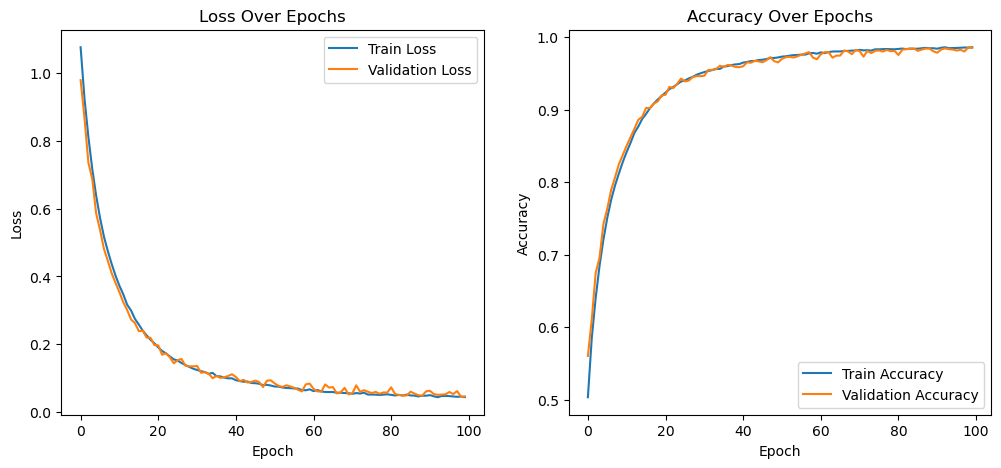

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Test Loss: 0.02441833841294283
Test Accuracy: 99.25%
Confusion Matrix:
[[1909    3    2    5]
 [   1  517    1    0]
 [   4   12 2914   11]
 [   0    0    4  316]]


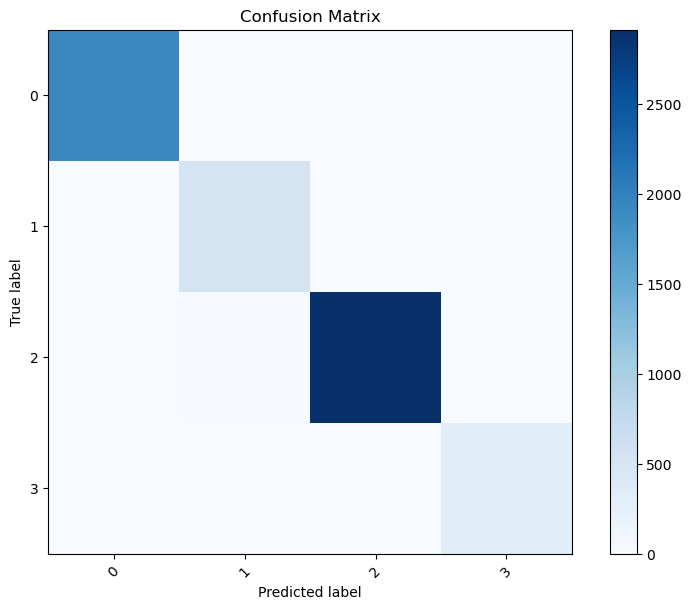

In [ ]:
# 테스트 데이터 로드 및 전처리
test_file_path = "C:\\Users\\jy\\Desktop\\code\\ReLabeling\\labeled\\Denormalize\\F28_combined.csv"
test_data = load_and_preprocess(test_file_path)

# 테스트 데이터도 다중 타임 스텝 데이터로 변환
X_test, y_test = create_multistep_data(test_data, time_steps)
y_test = y_test.astype(int)

# 테스트 데이터 텐서로 변환
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# 모델 평가
model.eval()
test_loss, correct = 0, 0
y_true, y_pred = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == y_batch).sum().item()
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

test_accuracy = correct / len(test_dataset)
conf_matrix = confusion_matrix(y_true, y_pred)
acc_score = accuracy_score(y_true, y_pred)

print(f"Test Loss: {test_loss / len(test_loader)}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print("Confusion Matrix:")
print(conf_matrix)

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(4)
plt.xticks(tick_marks, [0, 1, 2, 3], rotation=45)
plt.yticks(tick_marks, [0, 1, 2, 3])
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# 모델에 대한 입력값
x = torch.randn(1, 10, 3, requires_grad=True).cuda()
torch_out = model(x)

# 모델 변환
torch.onnx.export(model,               # 실행될 모델
                  x,                         # 모델 입력값 (튜플 또는 여러 입력값들도 가능)
                  "lstm_denorm2.onnx",   # 모델 저장 경로 (파일 또는 파일과 유사한 객체 모두 가능)
                  export_params=True,        # 모델 파일 안에 학습된 모델 가중치를 저장할지의 여부
                  opset_version=10,          # 모델을 변환할 때 사용할 ONNX 버전
                  do_constant_folding=True,  # 최적화시 상수폴딩을 사용할지의 여부
                  input_names = ['input'],   # 모델의 입력값을 가리키는 이름
                  output_names = ['output'], # 모델의 출력값을 가리키는 이름
                  dynamic_axes={'input' : {0 : 'batch_size'},    # 가변적인 길이를 가진 차원
                                'output' : {0 : 'batch_size'}})

c:\Users\jy\anaconda3\envs\jy3\lib\site-packages\torch\onnx\symbolic_opset9.py:4662: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(


In [ ]:
import onnx
from onnx import shape_inference

path = "./lstm_denorm2.onnx"
onnx.save(onnx.shape_inference.infer_shapes(onnx.load(path)), path)

In [ ]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("lstm_denorm2.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# ONNX 런타임에서 계산된 결과값
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
ort_outs = ort_session.run(None, ort_inputs)

# ONNX 런타임과 PyTorch에서 연산된 결과값 비교
# np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)

# print("Exported model has been tested with ONNXRuntime, and the result looks good!")

In [ ]:
print(ort_outs)

[array([[ 2.6291692,  0.1267459,  0.4408216, -3.246405 ]], dtype=float32)]


In [ ]:
print(torch_out)

tensor([[ 2.6280,  0.1267,  0.4424, -3.2462]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


In [ ]:
# import onnx

# # 모델 및 스케일러 저장 경로 설정
# save_dir = os.path.dirname(file_paths[0])
# model_save_path = os.path.join(save_dir, "lstm_model_test4.pth")
# onnx_model_save_path = os.path.join(save_dir, "lstm_model_test4.onnx")
# scaler_save_path = os.path.join(save_dir, "scaler.pkl")

# # 모델 저장
# torch.save(model.state_dict(), model_save_path)
# # with open(scaler_save_path, 'wb') as f:
# #     pickle.dump(scaler, f)

# # ONNX로 모델 저장
# dummy_input = torch.randn(1, time_steps, input_size).to(device)
# torch.onnx.export(model, dummy_input, onnx_model_save_path, input_names=['input'], output_names=['output'], dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}})

# print(f"LSTM 모델 저장: {model_save_path}")
# print(f"ONNX 모델 저장 경로: {onnx_model_save_path}")


In [ ]:
import onnx

onnx_model_path = "C:\\Users\\jy\\Desktop\\code\\ReLabeling\\lstm_denorm2.onnx"
onnx_model = onnx.load(onnx_model_path)

# 모델 그래프에서 입력 정보 추출
input_all = [node.name for node in onnx_model.graph.input]
input_initializer = [node.name for node in onnx_model.graph.initializer]
net_feed_input = list(set(input_all) - set(input_initializer))

for input_name in net_feed_input:
    input_tensor = [node for node in onnx_model.graph.input if node.name == input_name][0]
    input_dim = input_tensor.type.tensor_type.shape.dim
    print(f"Input Name: {input_name}")
    print(f"Input Shape: {[d.dim_value for d in input_dim]}")


Input Name: input
Input Shape: [0, 10, 3]


In [ ]:

# for node in onnx_model.graph.node:
#     print(f"Node: {node.name}, OpType: {node.op_type}")

# # 모델의 입력 차원 확인
# for input_tensor in onnx_model.graph.input:
#     print(f"Input Name: {input_tensor.name}")
#     dims = [dim.dim_value for dim in input_tensor.type.tensor_type.shape.dim]
#     print(f"Input Dims: {dims}")

In [ ]:
# import onnx

# onnx_model_path = "C:\\Users\\jy\\Desktop\\code\\ReLabeling\\labeled\\Labeling Data\\lstm_model_test2.onnx"
# onnx_model = onnx.load(onnx_model_path)

# # 모델의 그래프 정보 확인
# for input_tensor in onnx_model.graph.input:
#     print(input_tensor.name, input_tensor.type.tensor_type.shape)
